In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import tensorflow.keras as K
import glob


# LOAD DATASET

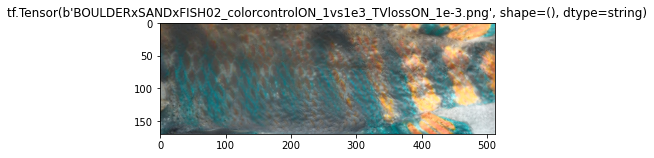

(170, 512, 3)


In [2]:
dataset = tf.data.Dataset.list_files("/home/durrmeyer/Images/StyleTransferImages/*/*.png")
    
def load_image(x):
    path = bytes.decode(x.numpy())
    img = imageio.imread(path).astype(np.uint8)
    img = tf.image.resize(img, [170, 512], method='nearest', preserve_aspect_ratio=True)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    label = tf.strings.split(path, os.sep)[-1]
    return img, label

ds = dataset.map(lambda x: tf.py_function(func=load_image,
          inp=[x], Tout=[tf.uint8, tf.string]), num_parallel_calls=-1)

for img, label in ds.take(1):
    plt.imshow(img)
    plt.title(label)
    plt.show()
    print(img.shape)

# CREATE NETWORK

In [3]:
(x_train, _), (x_test, _) = K.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
from tensorflow.keras.models import Model


latent_dim=64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            K.layers.Flatten(),
            K.layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            K.layers.Dense(784, activation='sigmoid'),
            K.layers.Reshape((28, 28))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [5]:
autoencoder.compile(optimizer='adam', loss=K.losses.MeanSquaredError())

In [6]:
history = autoencoder.fit(x_train, x_train,
                epochs=15,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0240 - val_loss: 0.0132
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.008

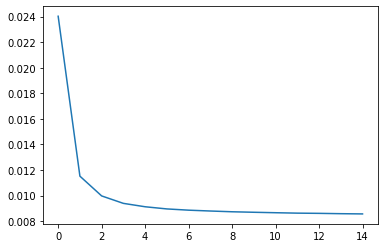

In [7]:
plt.plot(history.history["loss"])

NameError: name 'decoded_imgs' is not defined

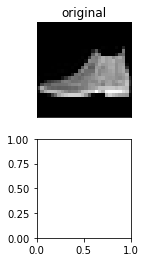

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [12]:
def divergence(start, repetition, visu=False):
    prev_decoded = start
    if visu: plt.figure(figsize=(20, 4))
    shift_decoded = []
    for i in range(repetition):
        if visu:
            ax = plt.subplot(repetition//10, 10, i+1)
            plt.imshow(prev_decoded[0])

        encoded = autoencoder.encoder(prev_decoded)
        new_decoded = autoencoder.decoder(encoded)

        shift_decoded.append(np.mean(np.square(start - prev_decoded), axis=(-1,-2)))
        prev_decoded = new_decoded.numpy()
    shift_decoded.append(np.mean(np.square(start - prev_decoded), axis=(-1,-2)))
    if visu: plt.show()
    return shift_decoded 

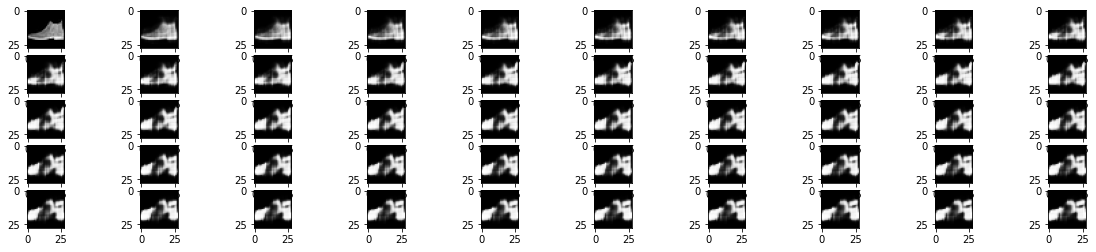

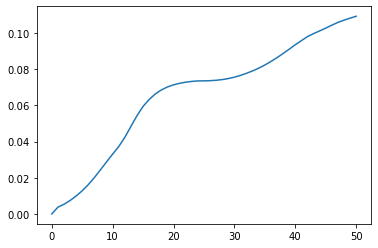

In [17]:
start = x_test[np.newaxis, 0]
shift = divergence(start, 50, True)

plt.plot(shift)

In [14]:
def order_by_divergence(x_test, num ,visu=True):
    last_shift=[]
    for i in range(num):
        start = x_test[np.newaxis, i]
        shift = divergence(start, num)
        plt.plot(shift)
        last_shift.append(shift[-1][0])
    plt.title("MSE divergence through iteration")
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.show()
    return x_test[np.argsort(last_shift)]

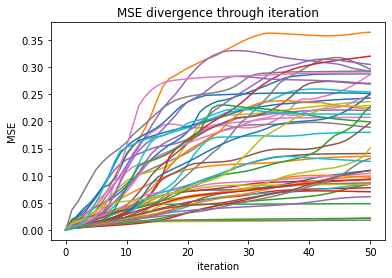

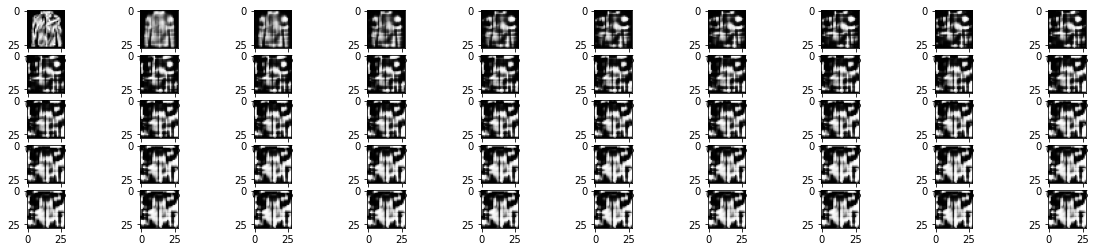

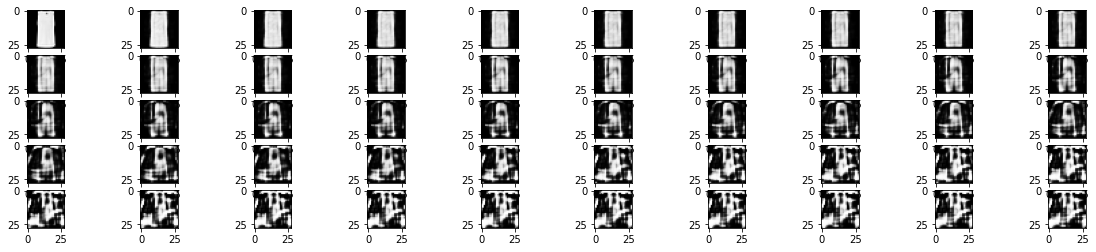

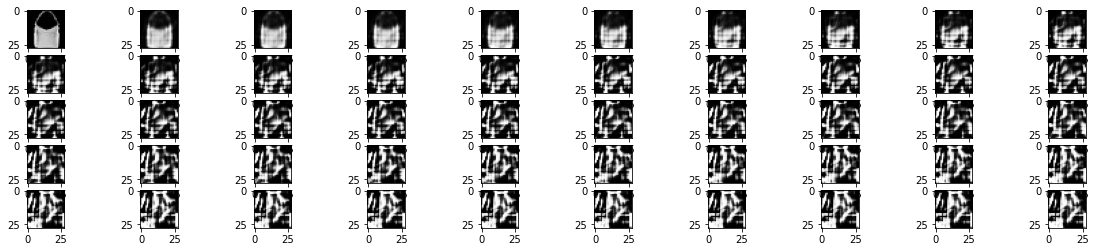

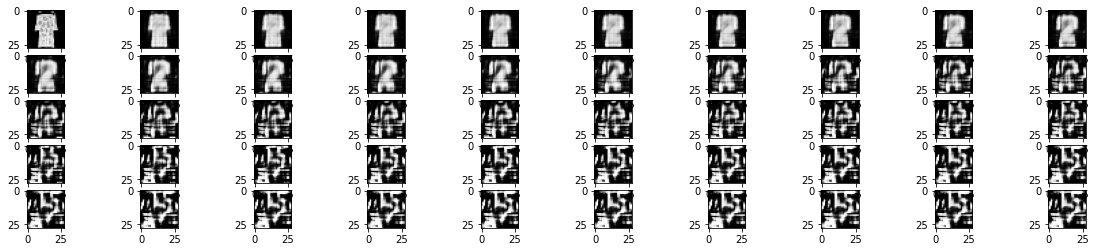

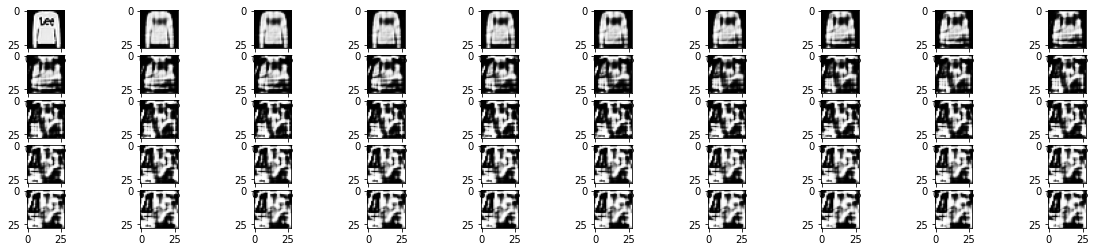

In [15]:
sorted_x = order_by_divergence(x_test, 50)
    
for x in sorted_x[-5:]:
    divergence(x[np.newaxis,...], 50, visu=True)

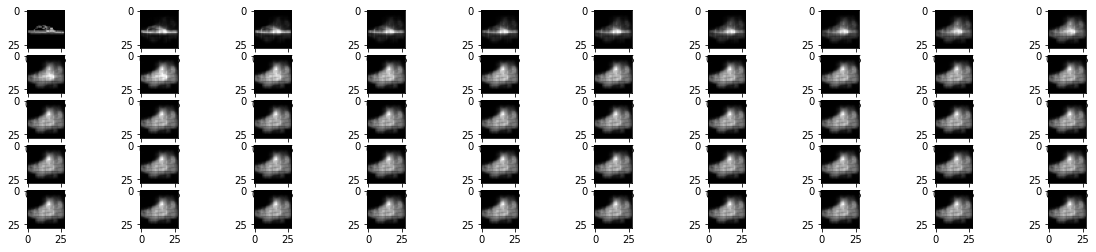

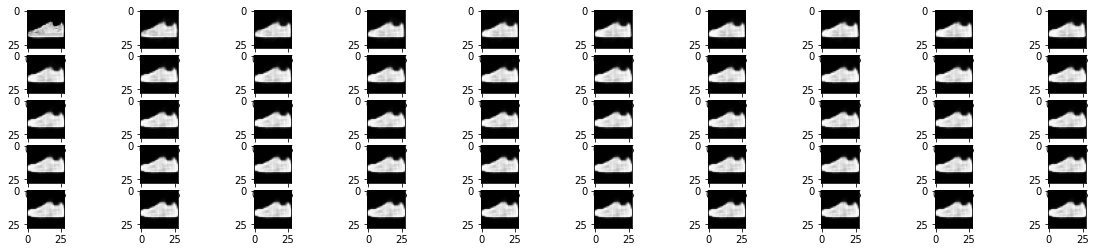

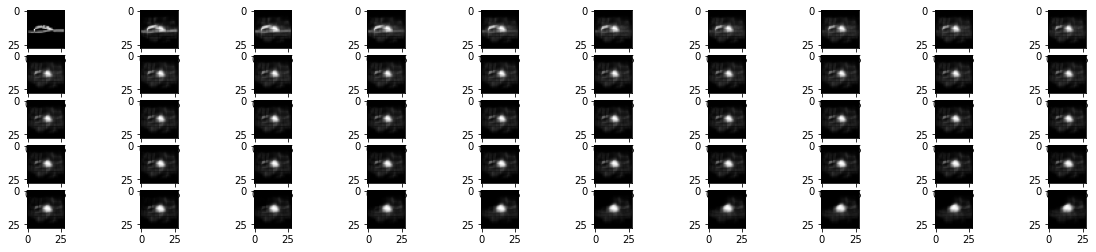

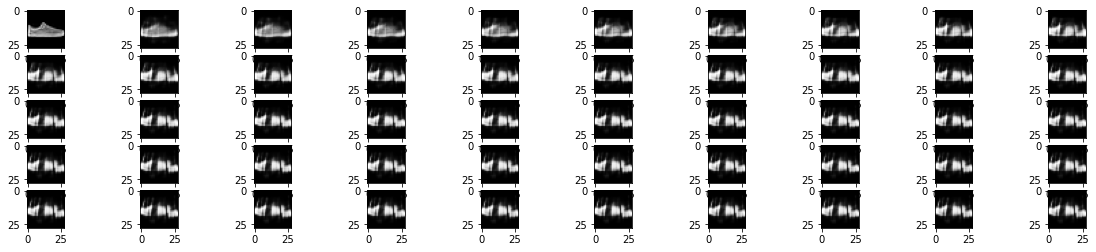

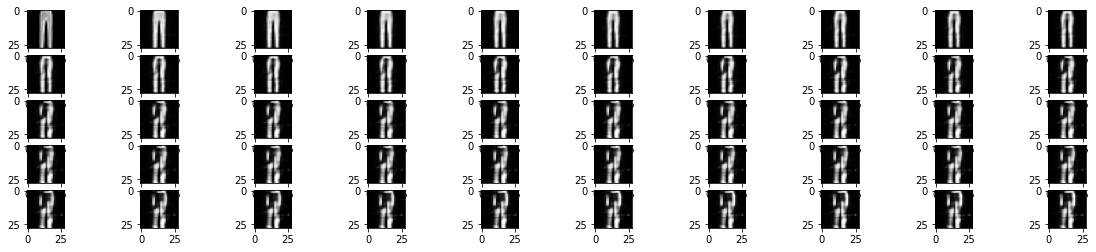

In [16]:
for x in sorted_x[:5]:
    divergence(x[np.newaxis,...], 50, visu=True)